# **JORNADA DE DADOS <Laboratória>**
# **PROJ005**

A VAREJISTA, empresa líder no setor, enfrenta o desafio de gerenciar grandes volumes de dados dispersos. Para aprimorar a tomada de decisões, está sendo implementado um sistema ETL robusto com tabelas fato e dimensões. O projeto visa extrair, transformar e carregar dados de forma eficiente, estruturando-os hierarquicamente para facilitar análises estratégicas. Além de otimizar o armazenamento, a iniciativa busca ampliar a capacidade da empresa de identificar padrões e oportunidades de mercado, respondendo com agilidade às mudanças na demanda do consumidor.
<br><br>
• [**DATASET**](https://github.com/4L4N4F/Python_ETLpipeline/blob/main/superstore.csv)
<br><br>
• **DESCRIÇÃO DAS VARIÁVEIS** <small>(Conforme fornecidas pela Laboratória na documentação do projeto.)</small>
<br><br>
| Variável       | Descrição                                                                        | Tipo      |
|----------------|----------------------------------------------------------------------------------|-----------|
| category       | Categoria do produto adquirido                                                   | STRING    |
| city           | Cidade onde o pedido foi feito                                                   | STRING    |
| country        | País onde o hipermercado está localizado                                         | STRING    |
| customer_id    | Identificador único para cada cliente                                             | STRING    |
| customer_name  | Nome do cliente                                                                  | STRING    |
| discount       | Desconto aplicado no pedido                                                      | FLOAT     |
| market         | Mercado ou região onde o hipermercado atua                                        | STRING    |
| unknown        | Coluna desconhecida ou não especificada                                           | INTEGER   |
| order_date     | Data do pedido                                                                    | TIMESTAMP |
| order_id       | Identificador único para cada pedido                                             | STRING    |
| order_priority | Nível de prioridade do pedido                                                     | STRING    |
| product_id     | Identificador exclusivo para cada produto                                        | STRING    |
| product_name   | Nome do produto                                                                  | STRING    |
| profit         | Lucro gerado pelo pedido                                                          | FLOAT     |
| quantity       | Quantidade de produtos encomendados no pedido                                    | INTEGER   |
| region         | Região onde o pedido foi feito                                                   | STRING    |
| row_id         | Identificador exclusivo para cada linha do conjunto de dados                      | INTEGER   |
| sales          | Valor total de vendas do produto no pedido                                       | INTEGER   |
| segment        | Segmento do cliente                                                              | STRING    |
| ship_date      | Data de envio do pedido                                                           | TIMESTAMP |
| ship_mode      | Modo de envio do pedido                                                          | STRING    |
| shipping_cost  | Custo de envio do pedido                                                         | FLOAT     |
| state          | Estado ou região do país                                                         | STRING    |
| sub_category   | Subcategoria do produto                                                          | STRING    |
| year           | Ano do pedido                                                                    | INTEGER   |
| market2        | Outra coluna relacionada a informações de mercado                               | STRING    |
| weeknum        | Número da semana em que o pedido foi feito                                       | INTEGER   |

<br><br>
• **ETAPAS:**<br>
1. Limpeza (df_limpo)<br>
2. Web scraping (df_multinacional_limpo)<br>
3. Construção de dimensões + fatos<br>
4. Preparação de atualizações (staging / merge) e upload para o BigQuery

In [ ]:
# SETUP

import unicodedata
import pandas as pd
import numpy as np
import re
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
from bs4 import BeautifulSoup
from google.cloud import bigquery
import os

df = pd.read_csv('https://github.com/4L4N4F/Python_ETLpipeline/raw/refs/heads/main/superstore.csv')

### Etapa 1. Limpeza

In [ ]:
# nulos
if df.isnull().values.any():
    print("Há valores nulos no DataFrame.")
else:
    print("Não há valores nulos no DataFrame.")

#duplicatas
if df.duplicated().any():
    print("Há linhas duplicadas no DataFrame.")
else:
    print("Não há linhas duplicadas no DataFrame.")

Não há valores nulos no DataFrame.
Não há linhas duplicadas no DataFrame.


In [ ]:
# definir as variáveis categóricas
df.columns = df.columns.str.lower()
cat_cols = df.select_dtypes(include='object').columns
print("variáveis:", cat_cols)

# não agir em colunas que devem ser id ou nome
df.columns = df.columns.str.lower()
cols_to_clean = [c for c in cat_cols if 'id' not in c and 'name' not in c and 'date' not in c]
print(cols_to_clean)



variáveis: Index(['category', 'city', 'country', 'customer_id', 'customer_name', 'market',
       'order_date', 'order_id', 'order_priority', 'product_id',
       'product_name', 'region', 'segment', 'ship_date', 'ship_mode', 'state',
       'sub_category', 'market2'],
      dtype='object')
['category', 'city', 'country', 'market', 'order_priority', 'region', 'segment', 'ship_mode', 'state', 'sub_category', 'market2']


In [ ]:
# padronização das categóricas
df_limpo = df.copy()
def padroniza_cols_to_clean(df, cols_to_clean):
    def remove_acentos(texto):
        if isinstance(texto, str):
            texto = unicodedata.normalize('NFKD', texto)
            texto = ''.join(c for c in texto if not unicodedata.combining(c))
        return texto
    for col in cols_to_clean:
        df[col] = df[col].astype(str).str.strip().str.lower().apply(remove_acentos)

    return df

# aplica função à cópia do df
df_limpo = padroniza_cols_to_clean(df_limpo, cols_to_clean)

# verificação sample
df_limpo[cols_to_clean].sample(10, random_state=42)



,category,city,country,market,order_priority,region,segment,ship_mode,state,sub_category,market2
49728,technology,philadelphia,united states,us,medium,east,consumer,second class,pennsylvania,accessories,north america
45547,office supplies,wollongong,australia,apac,medium,oceania,corporate,second class,new south wales,supplies,apac
15664,office supplies,galati,romania,emea,medium,emea,corporate,standard class,galati,binders,emea
40561,office supplies,lisbon,portugal,eu,medium,south,consumer,standard class,lisboa,paper,eu
49426,furniture,coral springs,united states,us,high,south,corporate,same day,florida,furnishings,north america
18956,office supplies,prague,czech republic,emea,medium,emea,consumer,standard class,prague,binders,emea
14238,office supplies,vienna,austria,emea,medium,emea,corporate,standard class,vienna,envelopes,emea
31818,office supplies,lagos,nigeria,africa,medium,africa,corporate,first class,lagos,art,africa
41388,furniture,buenos aires,argentina,latam,medium,south,consumer,standard class,buenos aires,chairs,latam
37236,office supplies,la ceiba,honduras,latam,high,central,corporate,standard class,atlantida,storage,latam


In [ ]:
# verificações das variáveis numéricas

num_cols = df_limpo.select_dtypes(include=['int64', 'float64']).columns

outliers_dict = {}
nulls_dict = {}
invalid_dict = {}

for col in num_cols:
    # nulos
    nulls_dict[col] = df_limpo[col].isnull().sum()

    # inválidos
    invalid_values = df_limpo[~df_limpo[col].apply(lambda x: np.isreal(x)) & df_limpo[col].notnull()]
    invalid_dict[col] = len(invalid_values)

    # outliers
    q1 = df_limpo[col].quantile(0.25)
    q3 = df_limpo[col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outliers = df_limpo[(df_limpo[col] < lower) | (df_limpo[col] > upper)]

    outliers_dict[col] = len(outliers)

variable_report = pd.DataFrame({
    'var': num_cols,
    'null': [nulls_dict[c] for c in num_cols],
    'inv': [invalid_dict[c] for c in num_cols],
    'outliers': [outliers_dict[c] for c in num_cols]
})

variable_report

,var,null,inv,outliers
0,discount,0,0,4172
1,unknown,0,0,0
2,profit,0,0,9755
3,quantity,0,0,877
4,row_id,0,0,0
5,sales,0,0,5655
6,shipping_cost,0,0,5909
7,year,0,0,0
8,weeknum,0,0,0


###Etapa 2. Web scraping

In [ ]:
wiki = "https://en.wikipedia.org/wiki/List_of_supermarket_chains"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
                  '(KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

try:
    req = Request(wiki, headers=headers)
    wiki_page = urlopen(req)
    soup = BeautifulSoup(wiki_page, 'html.parser')
    wiki_page.close()

    tabela = soup.find('table', class_='wikitable')
    if tabela is None:
        raise ValueError("tabela não encontrada")

    linhas = tabela.find_all('tr')
    cabecalho = [th.text.strip() for th in linhas[0].find_all('th')]

    dados = []
    for linha in linhas[1:]:
        colunas = linha.find_all(['td', 'th'])
        if len(colunas) > 0:
            dados.append([coluna.text.strip() for coluna in colunas])

    df_multinacional = pd.DataFrame(dados, columns=cabecalho)

    df_multinacional.columns = df_multinacional.columns.str.lower()
    df_multinacional = df_multinacional.drop(columns=['map'], errors='ignore')
    df_multinacional = df_multinacional.rename(columns={
        "served countries (besides the headquarters)": "countries",
        "number of locations": "locations",
        "number of employees": "employees"
    })

    def extract_number_clean(value):
        if pd.isna(value) or str(value).strip() == '':
            return None

        # remove vírgulas e pontos
        value_clean = str(value).replace(',', '').replace('.', '')
        match = re.search(r'\d+', value_clean)
        return int(match.group()) if match else None

    df_multinacional['locations'] = df_multinacional['locations'].apply(extract_number_clean)
    df_multinacional['employees'] = df_multinacional['employees'].apply(extract_number_clean)


    def count_countries(value):
        if pd.isna(value) or str(value).strip() == '':
            return 1
        return len([c.strip() for c in str(value).split(',') if c.strip() and c.strip() != 'nan'])

    df_multinacional['countries_count'] = df_multinacional['countries'].apply(count_countries)

    # abre cópia limpa e padroniza strings
    df_multinacional_limpo = df_multinacional.copy()
    for col in df_multinacional_limpo.select_dtypes(include='object').columns:
        df_multinacional_limpo[col] = df_multinacional_limpo[col].str.strip().str.lower()

    # verificação
    display(df_multinacional_limpo.head(10))

except (URLError, HTTPError) as e:
    print("Erro ao acessar a página:", e)
except Exception as e:
    print("Erro no processamento:", e)

,company,headquarters,countries,locations,employees,countries_count
0,7-eleven,japanunited states,"australia, canada, china, cambodia, denmark, h...",85000.0,170000.0,17
1,aeon,japan,"australia, cambodia, china, hong kong, india, ...",20008.0,560000.0,15
2,ahold delhaize,netherlands,"belgium (as albert heijn and delhaize), czech ...",7659.0,375000.0,14
3,aldi,germany (süd and nord),"australia (süd), austria (süd as hofer), china...",12832.0,274172.0,18
4,edeka,germany,denmark,13646.0,381000.0,1
5,extra,germany,,NaN,9700.0,1
6,minimal,germany,poland,1500.0,NaN,1
7,auchan,france,"spain, luxembourg, italy, portugal, poland, ro...",2101.0,160407.0,15
8,big c,thailand,"laos, vietnam",1234.0,27000.0,2
9,billa,austria,"bulgaria, czech republic, slovakia",3645.0,76174.0,3


###Etapa 3. Construção de dimensões + fatos

In [ ]:
# dim_tempo
df_limpo['order_date'] = pd.to_datetime(df_limpo['order_date'], errors='coerce')
dim_tempo = df_limpo[['order_date']].drop_duplicates().copy()
dim_tempo['date_id'] = dim_tempo['order_date'].dt.strftime('%Y%m%d').astype(int)
dim_tempo['year'] = dim_tempo['order_date'].dt.year
dim_tempo['month'] = dim_tempo['order_date'].dt.month
dim_tempo['day'] = dim_tempo['order_date'].dt.day
dim_tempo['weeknum'] = dim_tempo['order_date'].dt.isocalendar().week
dim_tempo['weekday'] = dim_tempo['order_date'].dt.weekday + 1  # 1=Segunda, 7=Domingo
dim_tempo = dim_tempo[['date_id', 'order_date', 'year', 'month', 'day', 'weeknum', 'weekday']]

In [ ]:
#dim_produto
dim_produto = df_limpo[['product_id', 'product_name', 'category', 'sub_category']].drop_duplicates().reset_index(drop=True)

In [ ]:
#dim_local
dim_localizacao = df_limpo[['region', 'country', 'state', 'city', 'market', 'market2']].drop_duplicates().copy()
dim_localizacao['location_id'] = range(1, len(dim_localizacao) + 1)
dim_localizacao = dim_localizacao[['location_id', 'region', 'country', 'state', 'city', 'market', 'market2']]

In [ ]:
#dim_cliente
dim_cliente = df_limpo[['customer_id', 'customer_name', 'segment']].drop_duplicates().reset_index(drop=True)

In [ ]:
#dim_expedicao
dim_envio = df_limpo[['ship_mode', 'ship_date', 'shipping_cost']].drop_duplicates().reset_index(drop=True)
dim_envio['shipping_id'] = dim_envio.index + 1
dim_envio = dim_envio[['shipping_id', 'ship_mode', 'ship_date', 'shipping_cost']]

In [ ]:
#dim_competition
dim_company = df_multinacional_limpo.copy().drop_duplicates().reset_index(drop=True)
dim_company['company_id'] = range(1, len(dim_company) + 1)
dim_company = dim_company[['company_id', 'company', 'headquarters', 'countries', 'countries_count', 'locations', 'employees']]

In [ ]:
#fato_orders

fato_vendas = df_limpo[['row_id', 'order_id', 'customer_id', 'product_id',
                        'order_date', 'region', 'country', 'state', 'city', 'market', 'market2',
                        'ship_mode', 'ship_date', 'shipping_cost',
                        'sales', 'profit', 'quantity', 'discount', 'order_priority']].copy()

#date-id
fato_vendas['date_id'] = fato_vendas['order_date'].dt.strftime('%Y%m%d').astype(int)

#local-id
fato_vendas = fato_vendas.merge(
    dim_localizacao[['location_id', 'region', 'country', 'state', 'city', 'market', 'market2']],
    on=['region', 'country', 'state', 'city', 'market', 'market2'],
    how='left'
)

#ship-id
fato_vendas = fato_vendas.merge(
    dim_envio,
    on=['ship_mode', 'ship_date', 'shipping_cost'],
    how='left'
)

fato_vendas = fato_vendas[['row_id', 'order_id', 'customer_id', 'product_id',
                           'date_id', 'location_id', 'shipping_id', 'order_priority',
                           'sales', 'profit', 'quantity', 'discount']]


In [ ]:
print("Dimensão Tempo")
display(dim_tempo.head())

print("Dimensão Localização")
display(dim_localizacao.head())

print("Dimensão Envio")
display(dim_envio.head())

print("Tabela de Fatos")
display(fato_vendas.head())

Dimensão Tempo


,date_id,order_date,year,month,day,weeknum,weekday
0,20110107,2011-01-07,2011,1,7,1,5
1,20110121,2011-01-21,2011,1,21,3,5
2,20110805,2011-08-05,2011,8,5,31,5
4,20110929,2011-09-29,2011,9,29,39,4
5,20111019,2011-10-19,2011,10,19,42,3


Dimensão Localização


,location_id,region,country,state,city,market,market2
0,1,west,united states,california,los angeles,us,north america
345,2,west,united states,california,san francisco,us,north america
593,3,west,united states,california,san diego,us,north america
661,4,west,united states,california,roseville,us,north america
662,5,west,united states,california,huntington beach,us,north america


Dimensão Envio


,shipping_id,ship_mode,ship_date,shipping_cost
0,1,second class,2011-01-09 0:00:00,4.37
1,2,standard class,2011-01-26 0:00:00,0.94
2,3,standard class,2011-08-09 0:00:00,1.81
3,4,standard class,2011-08-09 0:00:00,4.59
4,5,standard class,2011-10-03 0:00:00,1.32


Tabela de Fatos


,row_id,order_id,customer_id,product_id,date_id,location_id,shipping_id,order_priority,sales,profit,quantity,discount
0,36624,CA-2011-130813,LS-172304,OFF-PA-10002005,20110107,1,1,high,19,9.3312,3,0.0
1,37033,CA-2011-148614,MV-174854,OFF-PA-10002893,20110121,1,2,medium,19,9.2928,2,0.0
2,31468,CA-2011-118962,CS-121304,OFF-PA-10000659,20110805,1,3,medium,21,9.8418,3,0.0
3,31469,CA-2011-118962,CS-121304,OFF-PA-10001144,20110805,1,4,medium,111,53.2608,2,0.0
4,32440,CA-2011-146969,AP-109154,OFF-PA-10002105,20110929,1,5,high,6,3.1104,1,0.0


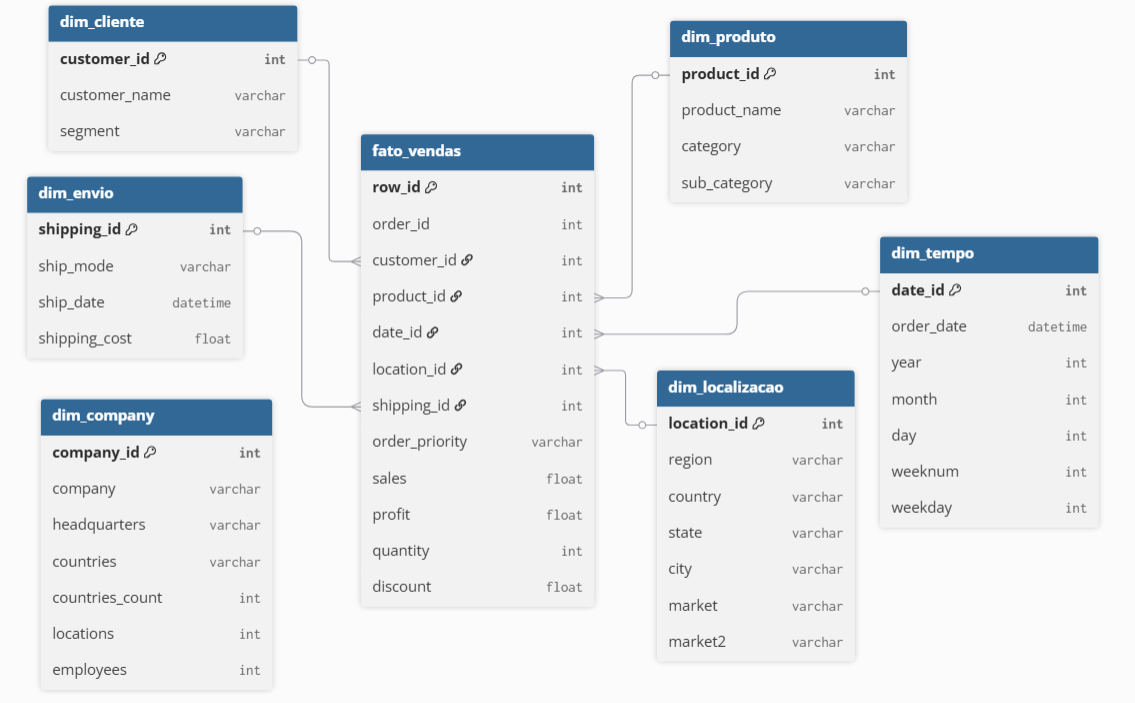

##Etapa 4. Preparação de atualizações (staging / merge) e upload para o BigQuery

Fluxo de atualização projetado:
1. Receber novos dados do dia (staging), que poderia ser por um .csv, um api ou um outro banco
2. Validar / deduplicar no staging
3. Merge/upsert no dataframe target
4. Ordem de atualização: dimensões primeiro, pois a tabela fato depende de chaves dessas dimensões; fato por último, usando IDs atualizados das dimensões

In [ ]:
# conectando ao BigQuery
client = bigquery.Client(project="proj005-474813")
dataset_name = "proj005"  # seu dataset
dataset_id = f"{client.project}.{dataset_name}"

# upload
def upload_to_bq(df, table_name, write_disposition="WRITE_TRUNCATE"):
    table_id = f"{dataset_id}.{table_name}"
    job_config = bigquery.LoadJobConfig(write_disposition=write_disposition)
    job = client.load_table_from_dataframe(df, table_id, job_config=job_config)
    job.result()
    print(f"Tabela {table_name} criada/atualizada no BigQuery.")

# merge
 # target: dataframe existente (simula BQ)
 # staging: dataframe novo (novos registros do dia)
 # key: coluna que identifica unicamente cada registro

def merge_pandas(target, staging, key):
    target = target.set_index(key)
    staging = staging.set_index(key)

    # atualiza registros
    target.update(staging)

    # adiciona registros
    new_rows = staging.index.difference(target.index)
    if len(new_rows):
        target = pd.concat([target, staging.loc[new_rows]])

    return target.reset_index()

# produto
stg_dim_produto = dim_produto.copy()  # novos registros
target_dim_produto = dim_produto  # tabela existente
target_dim_produto = merge_pandas(target_dim_produto, stg_dim_produto, key='product_id')

# tempo
stg_dim_tempo = dim_tempo.copy()
target_dim_tempo = merge_pandas(dim_tempo, stg_dim_tempo, key='date_id')

# cliente
stg_dim_cliente = dim_cliente.copy()
target_dim_cliente = merge_pandas(dim_cliente, stg_dim_cliente, key='customer_id')

# localização
stg_dim_localizacao = dim_localizacao.copy()
target_dim_localizacao = merge_pandas(dim_localizacao, stg_dim_localizacao, key='location_id')

# expedicao
stg_dim_envio = dim_envio.copy()
target_dim_envio = merge_pandas(dim_envio, stg_dim_envio, key='shipping_id')

# competição
stg_dim_company = dim_company.copy()
target_dim_company = merge_pandas(dim_company, stg_dim_company, key='company_id')

# fato
stg_fato_vendas = fato_vendas.copy()  # novos registros do dia (simulação)
target_fato_vendas = merge_pandas(fato_vendas, stg_fato_vendas, key='row_id')

# upload
upload_to_bq(target_dim_tempo, "dim_tempo")
upload_to_bq(target_dim_produto, "dim_produto")
upload_to_bq(target_dim_cliente, "dim_cliente")
upload_to_bq(target_dim_localizacao, "dim_localizacao")
upload_to_bq(target_dim_envio, "dim_envio")
upload_to_bq(target_dim_company, "dim_company")
upload_to_bq(target_fato_vendas, "fato_vendas")

print("✅ All good :)")


Tabela dim_tempo criada/atualizada no BigQuery.
Tabela dim_produto criada/atualizada no BigQuery.
Tabela dim_cliente criada/atualizada no BigQuery.
Tabela dim_localizacao criada/atualizada no BigQuery.
Tabela dim_envio criada/atualizada no BigQuery.
Tabela dim_company criada/atualizada no BigQuery.
Tabela fato_vendas criada/atualizada no BigQuery.
✅ All good :)
